In [1]:
# GENERAL IMPORTS

import torch
from mapping.datasets import RLDatasetFormatter
from mapping.models import Discriminator, TransitionModel, LitAutoEncoder

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# READING OF DATASETS

s_s_max = torch.tensor([0.6, 0.07])
s_s_min = torch.tensor([-1.2, -0.07])
s_a_max = torch.tensor([1.0])
s_a_min = torch.tensor([-1.0])

t_s_max = torch.tensor([0.6, 0.07])
t_s_min = torch.tensor([-1.2, -0.07])
t_a_max = torch.tensor([1.0])
t_a_min = torch.tensor([-1.0])

dataset_t_path = 'data/UntrainedMCDataset500.csv'
dataset_s_path = 'data/UntrainedMCDataset5000.csv'
dataset_s_path_2 = 'data/UntrainedMCDataset5000_2.csv'
dataset_t_path_ext = 'data/UntrainedMCDataset5000_2.csv'

data_formatter_t = RLDatasetFormatter().from_csv(dataset_t_path).normalize_data(t_s_max, t_s_min, t_a_max, t_a_min)
data_formatter_s = RLDatasetFormatter().from_csv(dataset_s_path).normalize_data(s_s_max, s_s_min, s_a_max, s_a_min)
data_formatter_s_2 = RLDatasetFormatter().from_csv(dataset_s_path_2).normalize_data(s_s_max, s_s_min, s_a_max, s_a_min)
data_formatter_t_ext = RLDatasetFormatter().from_csv(dataset_t_path_ext).normalize_data(t_s_max, t_s_min, t_a_max, t_a_min)

s_s_size = data_formatter_s.state_size
s_a_size = data_formatter_s.action_size
t_s_size = data_formatter_t.state_size
t_a_size = data_formatter_t.action_size 


In [3]:
AE_lr = 0.001
AE_epochs = 100
AE_batch_size = 50

AE = LitAutoEncoder(lr=AE_lr,
                    s_s_size=s_s_size, 
                    s_a_size=s_a_size, 
                    t_s_size=t_s_size, 
                    t_a_size=t_a_size)

AE.train_model(dataset=data_formatter_s.transition_identity(),
               batch_size=AE_batch_size,
               epochs=AE_epochs,
               logs_dir='test/')



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: test/lightning_logs

  | Name       | Type       | Params
------------------------------------------
0 | sfc_s      | Sequential | 8.5 K 
1 | actionfc_s | Sequential | 8.4 K 
2 | s1fc_s     | Sequential | 8.5 K 
3 | model_enc  | Sequential | 25.0 K
4 | sfc_t      | Sequential | 8.5 K 
5 | actionfc_t | Sequential | 8.4 K 
6 | s1fc_t     | Sequential | 8.5 K 
7 | model_dec  | Sequential | 25.0 K
------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.403     Total estimated model params size (MB)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/loggers/tensorboard.py:262: UserWarning: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Epoch 99: 100%|██████████| 100/100 [00:01<00:00, 91.78it/s, loss=7.66e-06, v_num=0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 100/100 [00:01<00:00, 90.77it/s, loss=7.66e-06, v_num=0]


In [4]:
dataset_s_2 = data_formatter_s_2.transition_identity()


sas, _ = dataset_s_2[:]
with torch.no_grad():
    reconstructed_data = AE.as_dict()['func'](sas)
    
#r_synth = torch.zeros((reconstructed_data.shape[0],1))
s_rec,a_rec,s1_rec = torch.split(reconstructed_data, [s_s_size, s_a_size, s_s_size],1)
#data_formatter_synth = RLDatasetFormatter([s_synth, a_synth, r_synth, s1_synth])
s, a, s1 = torch.split(sas, [s_s_size, s_a_size, s_s_size],1)

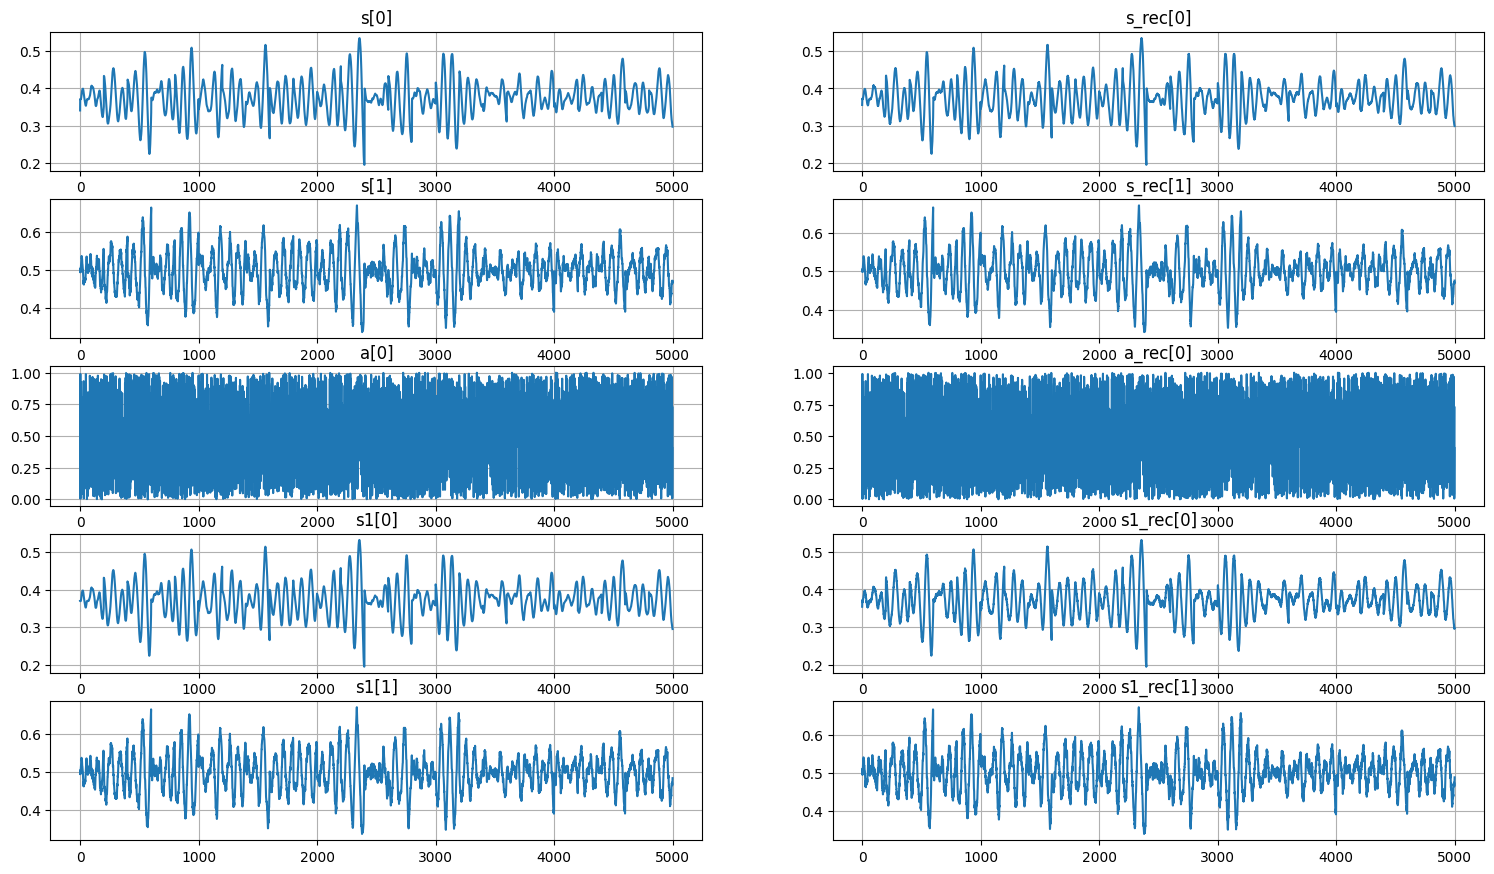

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2*s_s_size+s_a_size, 2)

for i in range(s_s_size):
    index_data = i
    axs[i, 0].plot(s[:,i].detach().numpy())
    axs[i, 0].set_title('s['+str(i)+"]")
    axs[i, 0].grid()
    axs[i, 1].plot(s_rec[:,i].detach().numpy())
    axs[i, 1].set_title('s_rec['+str(i)+"]")
    axs[i, 1].grid()
for i in range(s_s_size,s_a_size+s_s_size):
    index_data = i-s_s_size 
    axs[i, 0].plot(a[:,index_data].detach().numpy())
    axs[i, 0].set_title('a['+str(index_data)+"]")
    axs[i, 0].grid()
    axs[i, 1].plot(a_rec[:,index_data].detach().numpy())
    axs[i, 1].set_title('a_rec['+str(index_data)+"]")
    axs[i, 1].grid
for i in range(s_a_size+s_s_size,s_a_size+2*s_s_size):
    index_data = i-s_s_size-s_a_size
    axs[i, 0].plot(s1[:,index_data].detach().numpy())
    axs[i, 0].set_title('s1['+str(index_data)+"]")
    axs[i, 0].grid()
    axs[i, 1].plot(s1_rec[:,index_data].detach().numpy())
    axs[i, 1].set_title('s1_rec['+str(index_data)+"]")
    axs[i, 1].grid()
fig.set_size_inches(18.5, 10.5)
plt.show()

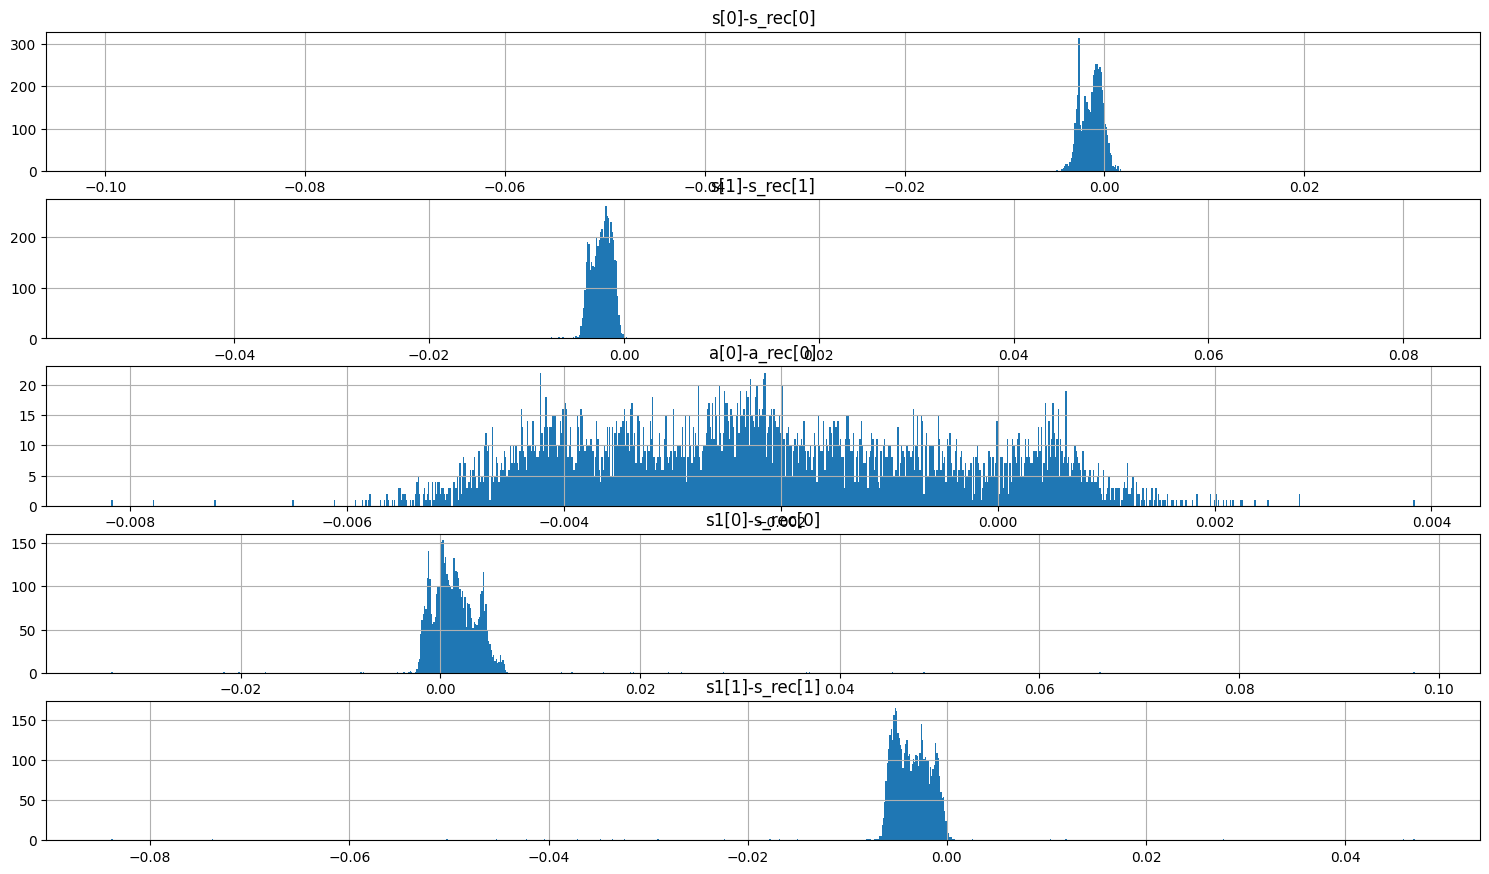

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2*s_s_size+s_a_size, 1)

err_s = s-s_rec
err_a = a-a_rec
err_s1 = s1-s1_rec


for i in range(s_s_size):
    axs[i].hist(err_s[:,i].detach().numpy(), bins=1000)
    axs[i].set_title('s['+str(i)+"]-s_rec["+str(i)+"]")
    axs[i].grid()
for i in range(s_s_size,s_a_size+s_s_size):
    index_data = i-s_s_size 
    axs[i].hist(err_a[:,index_data].detach().numpy(), bins=1000)
    axs[i].set_title('a['+str(index_data)+']-a_rec['+str(index_data)+"]")
    axs[i].grid()
for i in range(s_a_size+s_s_size,s_a_size+2*s_s_size):
    index_data = i-s_s_size-s_a_size
    axs[i].hist(err_s1[:,index_data].detach().numpy(), bins=1000)
    axs[i].set_title('s1['+str(index_data)+"]-s_rec["+str(index_data)+"]")
    axs[i].grid()
fig.set_size_inches(18.5, 10.5)
plt.show()